<a href="https://colab.research.google.com/github/Jushef/Cryptocurrency/blob/main/Estrategias%20de%20trading/BitcoinTradingStrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicción del precio del Bitcoin**
El objetivo de este proyecto es utilizar modelos basados en la clasificación para predecir si la señal actual es de compra o de venta en función del precio a corto plazo frente al precio a largo plazo.

##**Content**

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1) 
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.2. Preparing classification data](#3.2)
    * [4.3. Feature Engineering-Constructing Technical Indicators](#3.3)
    * [4.4.Data Visualisation](#3.4)
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3) 
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2) 
* [8. Backtesting](#7) 

<a id='0'></a>
# 1. Definición del problema

El problema de predecir una señal de compra o de venta para una estrategia de negociación se define en el marco de la clasificación, donde la variable predicha tiene un valor de 1 para la compra y de 0 para la venta.

La señal de compra o de venta se decide sobre la base de la comparación del precio a corto plazo con el precio a largo plazo.

Para el caso de estudio presentado, obtenemos los datos de una de las mayores bolsas de Bit-coin en términos de volumen medio diario negociado: Bitstamp (https:// www.bitstamp.com). Los datos pueden encontrarse en: https://www.kaggle.com/mczielinski/bitcoin-historical-data

<a id='1'></a>
# 2. Primeros pasos - Cargar los datos y los paquetes de Python

<a id='1.1'></a>
## 2.1. Carga de los paquetes python

In [8]:
# Carga de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Bibliotecas para modelos de aprendizaje profundo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

<a id='1.2'></a>
## 2.2. Cargando datos

In [9]:
dataset = pd.read_csv('/content/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [10]:
import warnings
warnings.filterwarnings('ignore')

<a id='2'></a>
# 3. Análisis exploratorio de datos

<a id='2.1'></a>
## 3.1. Estadísticas descriptivas

In [11]:
dataset.shape

(4857377, 8)

In [12]:
set_option('display.width', 100)
dataset.tail(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202
4857376,1617148800,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363


In [13]:
set_option('precision', 3)
dataset.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.857e+06,3.614e+06,3.614e+06,3.614e+06,3.614e+06,3.614e+06,3.614e+06,3.614e+06
mean,1.471e+09,6.009e+03,6.013e+03,6.004e+03,6.009e+03,9.323e+00,4.176e+04,6.009e+03
std,8.428e+07,8.996e+03,9.004e+03,8.989e+03,8.996e+03,3.055e+01,1.518e+05,8.996e+03
min,1.325e+09,3.800e+00,3.800e+00,1.500e+00,1.500e+00,0.000e+00,0.000e+00,3.800e+00
25%,1.398e+09,4.439e+02,4.440e+02,4.435e+02,4.439e+02,4.098e-01,4.521e+02,4.438e+02
50%,1.471e+09,3.597e+03,3.598e+03,3.596e+03,3.597e+03,1.980e+00,3.810e+03,3.597e+03
75%,1.544e+09,8.627e+03,8.633e+03,8.621e+03,8.627e+03,7.278e+00,2.570e+04,8.628e+03
max,1.617e+09,6.176e+04,6.178e+04,6.167e+04,6.178e+04,5.854e+03,1.390e+07,6.172e+04


<a id='3'></a>
# 4. Preparación de datos

<a id='3.1'></a>
## 4.1. Limpieza de datos

In [14]:
print('Null Values =',dataset.isnull().values.any())

Null Values = True


Dado que hay valores nulos, tenemos que limpiar los datos rellenando los NaN con los últimos valores disponibles.

In [15]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [16]:
dataset=dataset.drop(columns=['Timestamp'])

<a id='3.2'></a>
## 4.2. Preparación de los datos para su clasificación

Atribuimos una etiqueta a cada movimiento:

* 1 si la señal es que el precio a corto plazo subirá en comparación con el largo plazo.

* 0 si la señal es que el precio a corto plazo bajará en comparación con el largo plazo.

In [17]:
# Inicializar el DataFrame `signals` con la columna `signal`.
#datas['PriceMove'] = 0.0

# Crear una media móvil simple corta sobre la ventana corta
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# Crear una media móvil simple larga sobre la ventana larga
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# Crear señales
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [18]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal
4857372,58714.31,58714.31,58686.00,58686.00,1.384,81259.372,58692.753,58695.262,58667.759,1.0
4857373,58683.97,58693.43,58683.97,58685.81,7.295,428158.147,58693.227,58693.564,58667.410,1.0
4857374,58693.43,58723.84,58693.43,58723.84,1.706,100117.070,58696.198,58698.178,58667.708,1.0
4857375,58742.18,58770.38,58742.18,58760.59,0.720,42332.959,58761.866,58709.824,58668.532,1.0
4857376,58767.75,58778.18,58755.97,58778.18,2.713,159417.751,58764.349,58718.698,58670.551,1.0


<a id='3.3'></a>
## 4.3. Ingeniería de características

Comenzamos construyendo un conjunto de datos que contiene los predictores que se utilizarán para hacer las predicciones, y la variable de salida.

Los datos actuales del bicoin consisten en la fecha, la apertura, el máximo, el mínimo, el cierre y el volumen. Con estos datos calculamos los siguientes indicadores técnicos:

* **Promedio móvil :** Un promedio móvil proporciona una indicación de la tendencia del movimiento del precio cortando la cantidad de "ruido" en un gráfico de precios.

* **Oscilador estocástico %K y %D :** Un oscilador estocástico es un indicador de impulso que compara un precio de cierre concreto de un valor con un rango de sus precios durante un periodo de tiempo determinado. El %K y el %D son indicadores lentos y rápidos.

* **Índice de Fuerza Relativa (RSI):** Es un indicador de impulso que mide la magnitud de los cambios recientes en el precio para evaluar las condiciones de sobrecompra o sobreventa en el precio de una acción u otro activo.

* **Tasa de cambio (ROC):** Es un oscilador de momentum, que mide el cambio porcentual entre el precio actual y el precio pasado de n períodos.

* **Momentum (MOM) :** Es la tasa de aceleración del precio o del volumen de un valor, es decir, la velocidad a la que cambia el precio.

In [19]:
# cálculo de la media móvil exponencial

def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

# cálculo de la tasa de variación
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

# Cálculo del impulso de los precios
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

# cálculo del índice de fuerza relativa
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) # el primer valor es la suma de las ganancias medias
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) # el primer valor es la suma de las pérdidas medias
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

# cálculo del osilador estocástico.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

In [20]:
# Cálculo de la media móvil
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
4857372,58714.31,58714.31,58686.00,58686.00,1.384,81259.372,58692.753,58695.262,58667.759,1.0,58691.231,58675.538,58722.003,-0.029,-0.077,19.46,-6.46,51.544,50.298,49.479,35.393,61.578,51.697,68.138,39.264,47.840,58695.262,58676.974,58717.263
4857373,58683.97,58693.43,58683.97,58685.81,7.295,428158.147,58693.227,58693.564,58667.410,1.0,58690.246,58676.201,58721.643,0.014,-0.061,-16.98,-45.15,51.497,50.284,49.478,35.232,44.602,51.583,57.317,34.155,39.806,58693.564,58675.469,58717.926
4857374,58693.43,58723.84,58693.43,58723.84,1.706,100117.070,58696.198,58698.178,58667.708,1.0,58696.354,58679.274,58721.665,0.136,-0.042,46.14,2.19,59.662,53.064,49.822,67.380,46.002,74.385,59.222,41.881,38.433,58698.178,58675.542,58718.662
4857375,58742.18,58770.38,58742.18,58760.59,0.720,42332.959,58761.866,58709.824,58668.532,1.0,58708.033,58684.520,58722.052,0.121,0.027,116.46,12.14,65.837,55.549,50.153,91.131,64.581,94.261,73.410,51.701,42.579,58709.824,58675.947,58719.380
4857376,58767.75,58778.18,58755.97,58778.18,2.713,159417.751,58764.349,58718.698,58670.551,1.0,58720.787,58690.563,58722.610,0.133,0.072,88.74,33.30,68.409,56.684,50.310,100.000,86.170,100.000,89.549,56.401,49.994,58718.698,58677.057,58720.382


In [21]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
4857372,58714.31,58714.31,58686.00,58686.00,1.384,81259.372,58692.753,58695.262,58667.759,1.0,58691.231,58675.538,58722.003,-0.029,-0.077,19.46,-6.46,51.544,50.298,49.479,35.393,61.578,51.697,68.138,39.264,47.840,58695.262,58676.974,58717.263
4857373,58683.97,58693.43,58683.97,58685.81,7.295,428158.147,58693.227,58693.564,58667.410,1.0,58690.246,58676.201,58721.643,0.014,-0.061,-16.98,-45.15,51.497,50.284,49.478,35.232,44.602,51.583,57.317,34.155,39.806,58693.564,58675.469,58717.926
4857374,58693.43,58723.84,58693.43,58723.84,1.706,100117.070,58696.198,58698.178,58667.708,1.0,58696.354,58679.274,58721.665,0.136,-0.042,46.14,2.19,59.662,53.064,49.822,67.380,46.002,74.385,59.222,41.881,38.433,58698.178,58675.542,58718.662
4857375,58742.18,58770.38,58742.18,58760.59,0.720,42332.959,58761.866,58709.824,58668.532,1.0,58708.033,58684.520,58722.052,0.121,0.027,116.46,12.14,65.837,55.549,50.153,91.131,64.581,94.261,73.410,51.701,42.579,58709.824,58675.947,58719.380
4857376,58767.75,58778.18,58755.97,58778.18,2.713,159417.751,58764.349,58718.698,58670.551,1.0,58720.787,58690.563,58722.610,0.133,0.072,88.74,33.30,68.409,56.684,50.310,100.000,86.170,100.000,89.549,56.401,49.994,58718.698,58677.057,58720.382


In [22]:
# excluyendo las columnas que no son necesarias para nuestra predicción.

dataset=dataset.drop(['High','Low','Open', 'Volume_(Currency)','short_mavg','long_mavg'], axis=1)

In [23]:
dataset = dataset.dropna(axis=0)

In [24]:
dataset.tail()

,Close,Volume_(BTC),Weighted_Price,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
4857372,58686.00,1.384,58692.753,1.0,58691.231,58675.538,58722.003,-0.029,-0.077,19.46,-6.46,51.544,50.298,49.479,35.393,61.578,51.697,68.138,39.264,47.840,58695.262,58676.974,58717.263
4857373,58685.81,7.295,58693.227,1.0,58690.246,58676.201,58721.643,0.014,-0.061,-16.98,-45.15,51.497,50.284,49.478,35.232,44.602,51.583,57.317,34.155,39.806,58693.564,58675.469,58717.926
4857374,58723.84,1.706,58696.198,1.0,58696.354,58679.274,58721.665,0.136,-0.042,46.14,2.19,59.662,53.064,49.822,67.380,46.002,74.385,59.222,41.881,38.433,58698.178,58675.542,58718.662
4857375,58760.59,0.720,58761.866,1.0,58708.033,58684.520,58722.052,0.121,0.027,116.46,12.14,65.837,55.549,50.153,91.131,64.581,94.261,73.410,51.701,42.579,58709.824,58675.947,58719.380
4857376,58778.18,2.713,58764.349,1.0,58720.787,58690.563,58722.610,0.133,0.072,88.74,33.30,68.409,56.684,50.310,100.000,86.170,100.000,89.549,56.401,49.994,58718.698,58677.057,58720.382


<a id='3.4'></a>
## 4.4. Visualización de datos

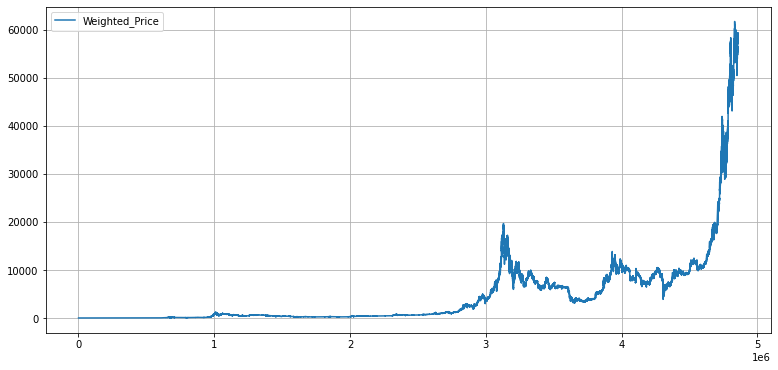

In [25]:
dataset[['Weighted_Price']].plot(grid=True, figsize=(13,6))
plt.show()

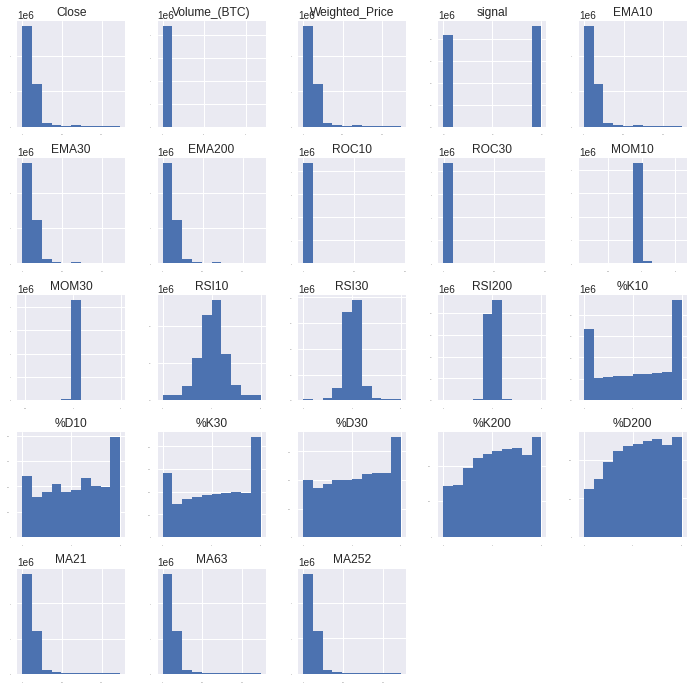

In [26]:
plt.style.use('seaborn')
# histogramas
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

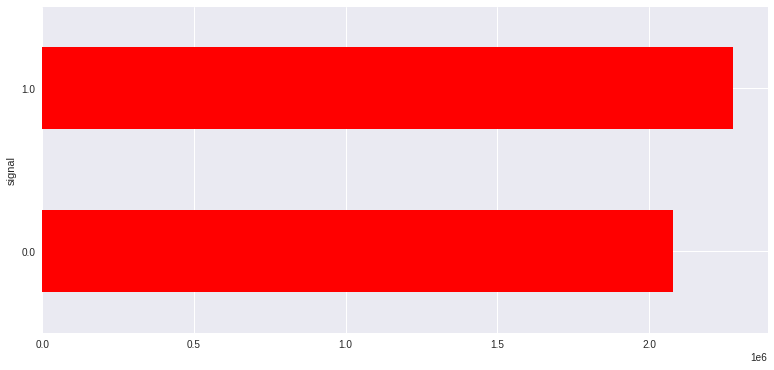

In [27]:
fig = plt.figure(figsize=(13,6))
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

* La variable pronosticada es ascendente al tamaño total de los datos, lo que significa que el número de señales de compra fue mayor que el número de señales de venta.

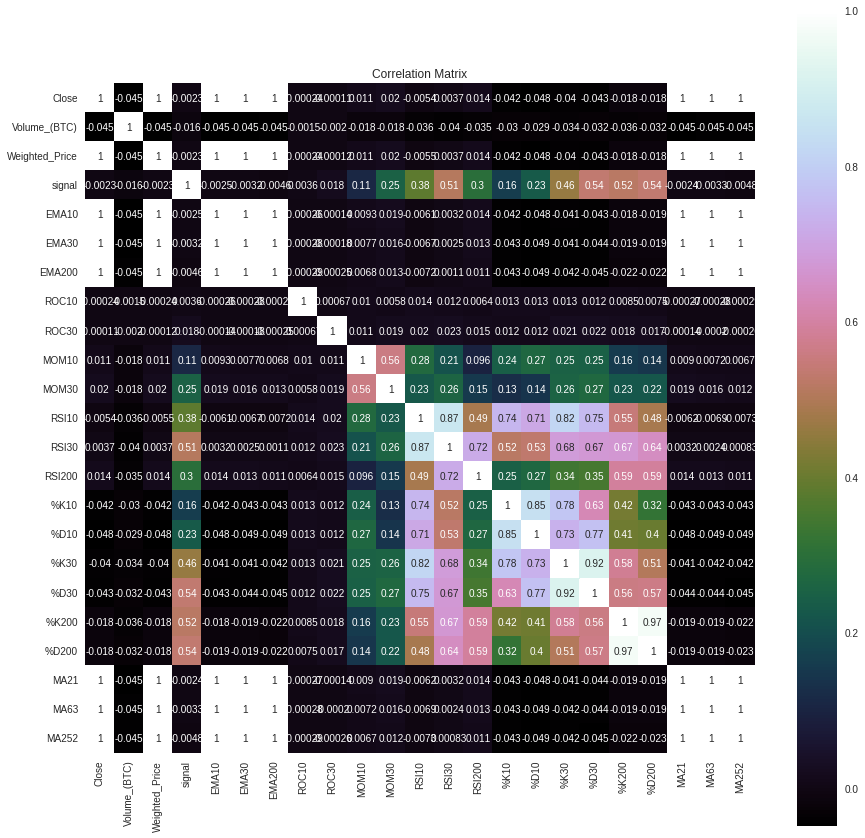

In [28]:
# correlacion
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<a id='4'></a>
# 5. Evaluar algoritmos y modelos

<a id='4.1'></a>
## 5.1. Train Test Split
Dividimos el conjunto de datos en un 80% de entrenamiento y un 20% de prueba.


In [29]:
# dividir el conjunto de datos de validación para el final  

subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal'] 

validation_size = 0.2
seed = 1

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

<a id='4.2'></a>
## 5.2. Opciones de prueba y métricas de evaluación


In [32]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

<a id='4.3'></a>
## 5.3. Comparar modelos y algoritmos

<a id='4.3.1'></a>
### 5.3.1. Modelos

In [33]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

#Neural Network
models.append(('NN', MLPClassifier()))

#Ensable Models 

# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

### K-folds cross validation

In [34]:
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.933438 (0.020925)
LDA: 0.918713 (0.003308)
KNN: 0.928600 (0.002702)
CART: 0.898175 (0.002611)
NB: 0.800000 (0.004392)
NN: 0.807125 (0.039166)
AB: 0.914312 (0.002408)
GBM: 0.923800 (0.002724)
RF: 0.929763 (0.002796)


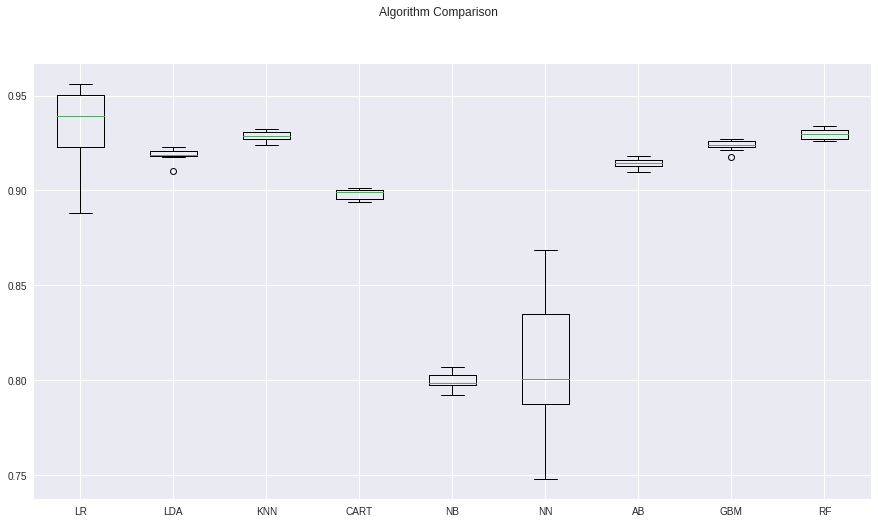

In [35]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

<a id='5'></a>
# 6. Ajuste del modelo y búsqueda en la cuadrícula

Se selecciona el bosque aleatorio para la búsqueda en la cuadrícula porque es uno de los mejores modelos de todos

In [37]:
# Grid Search: Random Forest Classifier
'''
n_estimators : int (por defecto=100)
    El número de etapas de refuerzo a realizar. 
    El refuerzo de gradiente es bastante robusto al sobreajuste, por lo que un número grande suele dar lugar a un mejor rendimiento.
max_depth : entero, opcional (por defecto=3)
    profundidad máxima de los estimadores de regresión individuales. 
    La profundidad máxima limita el número de nodos del árbol. 
    Ajuste este parámetro para obtener el mejor rendimiento; el mejor valor depende de la interacción de las variables de entrada    
criterion : cadena, opcional (por defecto="gini")
    La función para medir la calidad de una división. 
    Los criterios admitidos son "gini" para la impureza de Gini y "entropía" para la ganancia de información. 
    
'''   
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# Imprimir Resultados
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.917075 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.887862 (0.003683) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#5 0.889300 (0.003985) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.914788 (0.002472) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#1 0.917075 (0.002085) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.885150 (0.005581) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#6 0.887963 (0.004194) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.914437 (0.002794) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#2 0.916038 (0.001630) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


<a id='6'></a>
# 7. Finalizar el modelo

Finalizar el modelo con los mejores parámetros encontrados durante el paso de ajuste.

<a id='6.1'></a>
## 7.1. Resultados en el conjunto de datos de prueba

In [38]:
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression() 
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [39]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)

print(f'Accuracy score: {accuracy_score(Y_validation, predictions)}')
print('\n')
print(f'Confusion matrix: \n{confusion_matrix(Y_validation, predictions)}')
print('\n')
print(f'Classification report: \n{classification_report(Y_validation, predictions)}')

Accuracy score: 0.9171


Confusion matrix: 
[[8555  858]
 [ 800 9787]]


Classification report: 
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      9413
         1.0       0.92      0.92      0.92     10587

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000



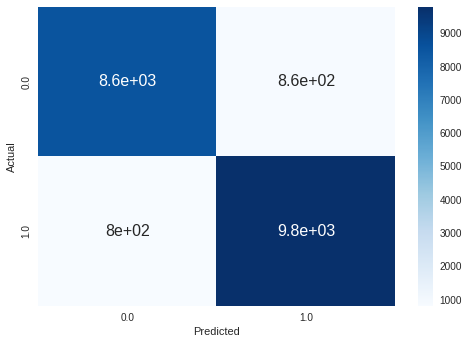

In [40]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

<a id='6.2'></a>
## 7.2. Intuición de las variables/importancia de las características
Veamos la importancia de las características del modelo

Text(0.5, 0, 'Variable Importance')

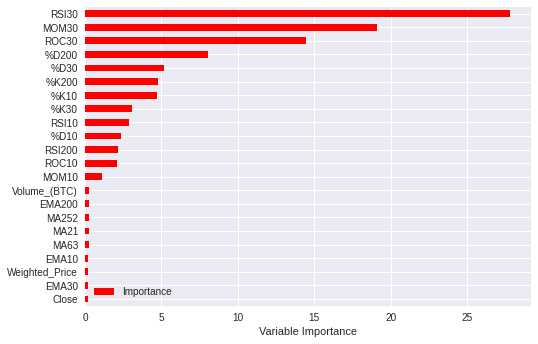

In [41]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

<a id='7'></a>
## 8. Resultados del Backtesting 

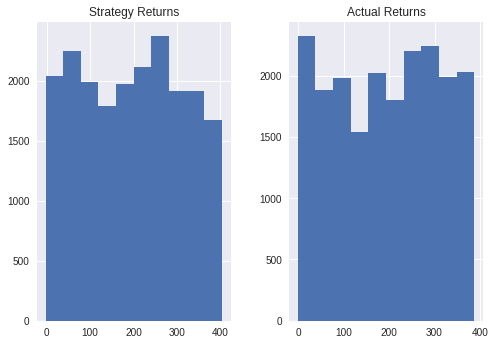

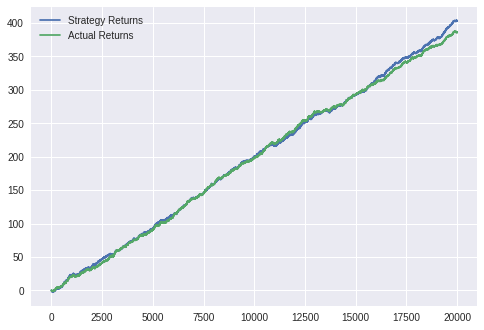

In [42]:
# Crear una columna para los rendimientos de la estrategia multiplicando los rendimientos diarios por la posición que se tenía al cierre del día anterior
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()